<a href="https://colab.research.google.com/github/theoVasilas/NN_training/blob/main/MINIST_CNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## dowload dataset and imports

In [1]:
%%capture
%pip install torch
%pip install torchvision
#captured_output.show()

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.utils import io
import numpy as np


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4498202.94it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 57941.31it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:06<00:00, 241773.97it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4534760.48it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
print(train_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## tranforms


In [6]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = False,
    transform = transform_train
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = False,
    transform=transform_test
)

## loaders

In [7]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'valid' : torch.utils.data.DataLoader(val_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)
}


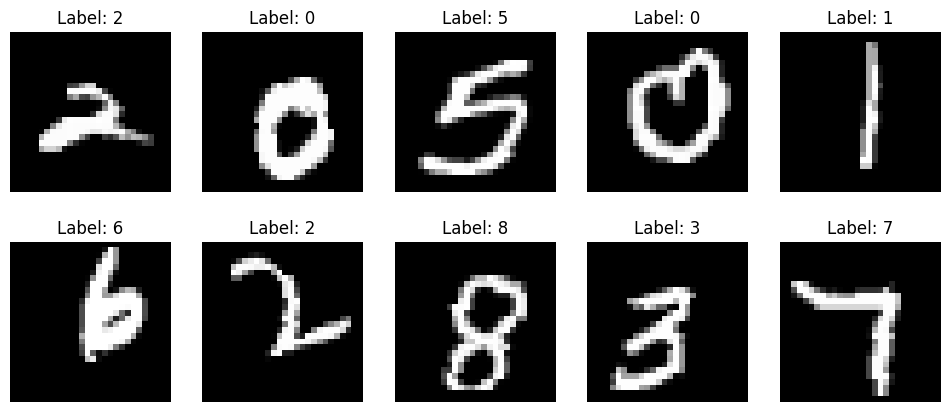

In [8]:
train_loader = loaders['train']
data_iter = iter(train_loader)

# Plot 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    images, labels = next(data_iter)
    ax = axes[i // 5, i % 5]
    ax.imshow(images[0].permute(1, 2, 0).squeeze(), cmap='gray')  # Assuming images are in CHW format
    ax.set_title(f"Label: {labels[0]}")
    ax.axis('off')

plt.show()

## Simple CNN

In [9]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


model = CNN()

## My_CNN

In [10]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.Dropout2d(p=0.1)
        )


        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=24,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.1)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=32,
                kernel_size=2,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.3)

        )

        self.linear1 = nn.Linear(in_features=32 * 7 * 7, out_features=24)

        self.drop = nn.Dropout(p=0.3)

        self.linear2 = nn.Linear(in_features=24, out_features=num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = x.view(-1, 32 * 7 * 7)

        x = self.linear1(x)
        x = nn.functional.relu(x)

        x = self.drop(x)

        x = self.linear2(x)

        output = torch.log_softmax(x, dim=1)
        return output

model = Net(num_classes=10).to(device)

print(model)


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (linear1): Linear(in_features=1568, out_features=24, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=24, out_features=10, bias=True)
)


In [14]:
%%capture
!pip install torchviz

import torch
from torchviz import make_dot


dummy_input = torch.randn(1, 1, 28, 28).to(device)

dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

dot.render("CNN_visualization", format="png")

dot

## updated training


In [18]:
import os
# os.environ["OMP_NUM_THREADS"] = "1"

# Now import JAX
import jax

def train(model, loaders = loaders , num_epochs=20, loss_func = None , optimizer = None):

    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = images.requires_grad_(True).to(device)
            b_y = labels.to(device)

            output = model(b_x)
            loss = loss_func(output, b_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(output.data, 1)
            total_train += b_y.size(0)
            correct_train += (predicted_train == b_y).sum().item()

        train_loss = running_loss / len(loaders['train'])
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in loaders['valid']:
                b_x = images.requires_grad_(False).to(device)
                b_y = labels.to(device)

                output = model(b_x)
                loss = loss_func(output, b_y)
                val_loss += loss.item()

                _, predicted_val = torch.max(output.data, 1)
                total_val += b_y.size(0)
                correct_val += (predicted_val == b_y).sum().item()

        val_loss /= len(loaders['valid'])
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


Epoch [1/5], Train Loss: 1.1282, Train Accuracy: 59.71%, Val Loss: 0.3688, Val Accuracy: 90.72%
Epoch [2/5], Train Loss: 0.1961, Train Accuracy: 94.12%, Val Loss: 0.1430, Val Accuracy: 95.78%
Epoch [3/5], Train Loss: 0.1432, Train Accuracy: 95.72%, Val Loss: 0.1352, Val Accuracy: 96.09%
Epoch [4/5], Train Loss: 0.1304, Train Accuracy: 96.01%, Val Loss: 0.1817, Val Accuracy: 94.68%
Epoch [5/5], Train Loss: 0.1192, Train Accuracy: 96.44%, Val Loss: 0.1177, Val Accuracy: 96.61%


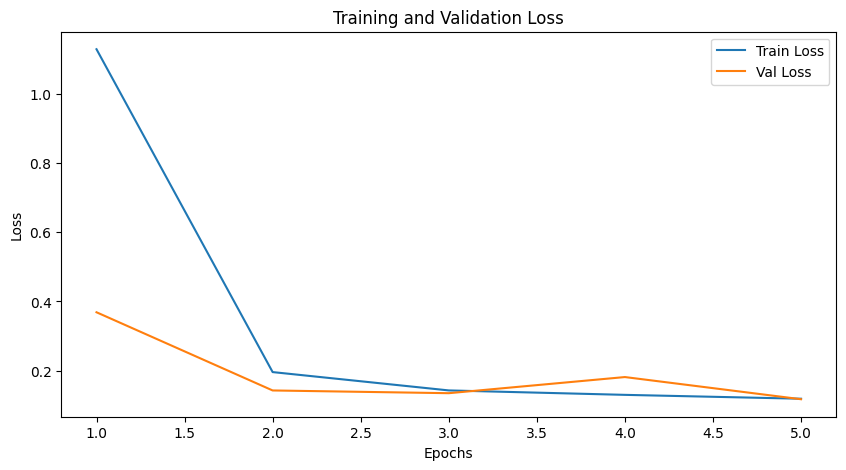

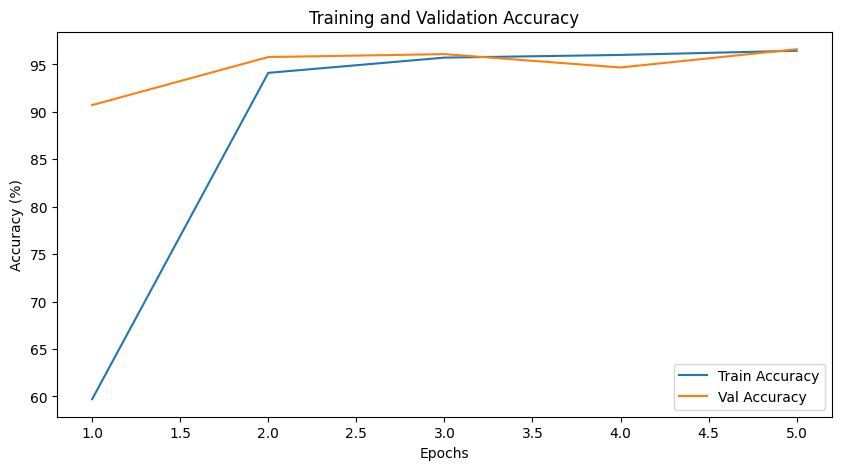

In [21]:
from torch import optim

learning_rate = 0.01

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

loss_func = nn.CrossEntropyLoss()

train(model, num_epochs = 5 , loss_func = loss_func, optimizer = optimizer)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
torch.save(model, "model_dropout_trained_model.pt")

!cp  model_dropout_trained_model.pt /content/drive/MyDrive/Sxoli/EFREMIDIS

cnn = torch.load('/content/drive/MyDrive/Sxoli/EFREMIDIS/model_dropout_trained_model.pt')

<ipython-input-23-ab5d637eae1e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn = torch.load('/content/drive/MyDrive/Sxoli/EFREMIDIS/model_dropout_trained_model.pt')


## test

In [26]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in loaders['test']:
          # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

    pass

test(cnn)

Test Accuracy of the model on the 10000 test images: 0.99


In [29]:
from sklearn.metrics import confusion_matrix

def test(cnn, loaders):
    model.eval()
    with torch.no_grad():
        all_predicted_labels = []
        all_true_labels = []

        for images, labels in loaders['test']:
            # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            all_predicted_labels.extend(pred_y.tolist())
            all_true_labels.extend(labels.tolist())

        # Calculate Test Accuracy
        accuracy = (torch.tensor(all_predicted_labels) == torch.tensor(all_true_labels)).float().mean().item()
        print('Test Accuracy of the model on the test set: %.2f' % accuracy)

        # Calculate Confusion Matrix
        cm = confusion_matrix(all_true_labels, all_predicted_labels)
        print('Confusion Matrix:\n', cm)

        # Calculate accuracy for each class
        class_accuracies = np.diag(cm) / cm.sum(axis=1)
        for i, acc in enumerate(class_accuracies):
            print(f'Accuracy for class {i}: {acc:.2f}')

        # Visualize wrongly predicted images
        #visualize_wrong_predictions(images, all_predicted_labels, all_true_labels)

    return all_predicted_labels, all_true_labels

all_predicted_labels, all_true_labels = test(cnn, loaders)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Accuracy of the model on the test set: 0.98
Confusion Matrix:
 [[ 974    0    2    0    0    1    0    0    1    2]
 [   0 1125    2    1    0    1    1    5    0    0]
 [   1    3 1010    1    0    0    0   11    6    0]
 [   0    0    0 1006    0    2    0    1    0    1]
 [   0    1    0    0  969    0    0    0    1   11]
 [   0    0    0   12    0  877    1    1    0    1]
 [   5    3    1    0    5   20  921    0    3    0]
 [   0    2    2    0    3    0    0 1013    2    6]
 [   4    0    2    1    1    7    3    1  941   14]
 [   0    0    2    1    8    1    0    2    3  992]]
Accuracy for class 0: 0.99
Accuracy for class 1: 0.99
Accuracy for class 2: 0.98
Accuracy for class 3: 1.00
Accuracy for class 4: 0.99
Accuracy for class 5: 0.98
Accuracy for class 6: 0.96
Accuracy for class 7: 0.99
Accuracy for class 8: 0.97
Accuracy for class 9: 0.98


In [33]:
import math

def wrong_images():
    model.eval()
    with torch.no_grad():
        wrong_sum = 0

        for images, labels in loaders['test']:
            # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            wrong_indices = (pred_y != labels).nonzero(as_tuple=True)[0]
            wrong_indices = wrong_indices[:20]

            # Skip batch if no misclassified images
            if len(wrong_indices) == 0:
                continue

            wrong_sum += len(wrong_indices)

            for i, idx in enumerate(wrong_indices):
                wrong_predicted_label = pred_y[idx].item()
                wrong_true_label = labels[idx].item()

                print(f'Image index {idx}: Predicted = {wrong_predicted_label}, True = {wrong_true_label}')

        print(f'Total number of wrong predictions: {wrong_sum}')

wrong_images()


Image index 49: Predicted = 1, True = 7
Image index 21: Predicted = 8, True = 2
Image index 46: Predicted = 7, True = 5
Image index 69: Predicted = 7, True = 2
Image index 69: Predicted = 5, True = 6
Image index 54: Predicted = 8, True = 4
Image index 4: Predicted = 4, True = 9
Image index 18: Predicted = 7, True = 1
Image index 84: Predicted = 9, True = 8
Image index 60: Predicted = 7, True = 9
Image index 46: Predicted = 6, True = 5
Image index 69: Predicted = 5, True = 1
Image index 4: Predicted = 2, True = 8
Image index 53: Predicted = 9, True = 4
Image index 66: Predicted = 9, True = 4
Image index 71: Predicted = 4, True = 9
Image index 52: Predicted = 9, True = 0
Image index 83: Predicted = 8, True = 6
Image index 92: Predicted = 5, True = 6
Image index 34: Predicted = 9, True = 8
Image index 91: Predicted = 9, True = 7
Image index 60: Predicted = 3, True = 5
Image index 73: Predicted = 6, True = 8
Image index 84: Predicted = 9, True = 8
Image index 90: Predicted = 5, True = 6
Im